# 1-Step SARSA 

This notebook shows the tabular reinforcement learning algorithm, 1-step SARSA applied to the Taxi problem (it also works on CliffWalking and FrozenLake) from Open AI's gym. 1-step SARSA is an on-policy Temporal Difference control algorithm. The algorithm is defined by: 
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q(S_{t + 1}, A_{t + 1}) - Q(S_t, A_t)]$$
, where $Q$ is the learned action-value function, $R$ is the reward, $A$ is the action, $\alpha$ is the step size, $\gamma$ is the discount rate and $t$ is the time step.

For more information on the SARSA algorithm see section 6.4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of 1-step SARSA see: [SARSA Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/TD/SARSA%20Solution.ipynb).

In [1]:
import gym
import numpy as np
from gym.wrappers import RecordVideo
from IPython.display import Video

In [2]:
# Type of environment, options include:
# Taxi-v3, CliffWalking-v0, FrozenLake-v1
ENV_TYPE = "Taxi-v3"

# Save videos from training
SAVE_VIDEOS = True

In [7]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

if SAVE_VIDEOS:
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder='./videos/',
        episode_trigger=lambda episode: episode % 100 == 0,
        video_length=0,
        name_prefix="sarsa"
        )

# Number of possible states and actions
num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
Q = np.zeros([num_states, num_actions])

/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/ubuntu20/code/rl-tabular-algorithms/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Create An $\epsilon$-Greedy Policy 

In [4]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Find the best action
    best_action = np.argmax(Q[state, :])
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [8]:
# Number of episodes to train on
episodes = 401
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.618
# Probability of taking a non-greedy action
epsilon = 0.01

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    action_dist = policy_fn(state, Q, epsilon, num_actions)
    action = np.random.choice(np.arange(num_actions), p=action_dist)

    while not terminated:
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        # Select the next action following the epsilon-greedy policy
        next_action_dist = policy_fn(next_state, Q, epsilon, num_actions)
        next_action = np.random.choice(np.arange(num_actions), p=next_action_dist)
        # Update the expected return for the action-value function
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action]) 
        G += reward
        state = next_state
        action = next_action

    returns.append(G)

    if episode % 10 == 0:
        print(f'Episode: {episode} Return: {G}')

Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-0.mp4
Episode: 10 Return: -3811
Episode: 20 Return: -74
Episode: 30 Return: -133
Episode: 40 Return: -101
Episode: 50 Return: -5
Episode: 60 Return: -79
Episode: 70 Return: -40
Episode: 80 Return: -141
Episode: 90 Return: -34
Episode: 100 Return: -13
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-100.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-100.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-100.mp4
Episode: 110 Return: -35


Episode: 120 Return: -93
Episode: 130 Return: -8
Episode: 140 Return: -8
Episode: 150 Return: -127
Episode: 160 Return: 10
Episode: 170 Return: -2
Episode: 180 Return: -41
Episode: 190 Return: 13
Episode: 200 Return: 5
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-200.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-200.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-200.mp4
Episode: 210 Return: 7
Episode: 220 Return: 6
Episode: 230 Return: -8
Episode: 240 Return: -91
Episode: 250 Return: 5
Episode: 260 Return: 6
Episode: 270 Return: 8
Episode: 280 Return: -2
Episode: 290 Return: 6


Episode: 300 Return: 11
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-300.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-300.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-300.mp4
Episode: 310 Return: 11
Episode: 320 Return: 11
Episode: 330 Return: 8
Episode: 340 Return: 10


Episode: 350 Return: 8
Episode: 360 Return: 2
Episode: 370 Return: 7
Episode: 380 Return: 7
Episode: 390 Return: 6
Episode: 400 Return: -1
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-400.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-400.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/sarsa-episode-400.mp4


## Plot The Results

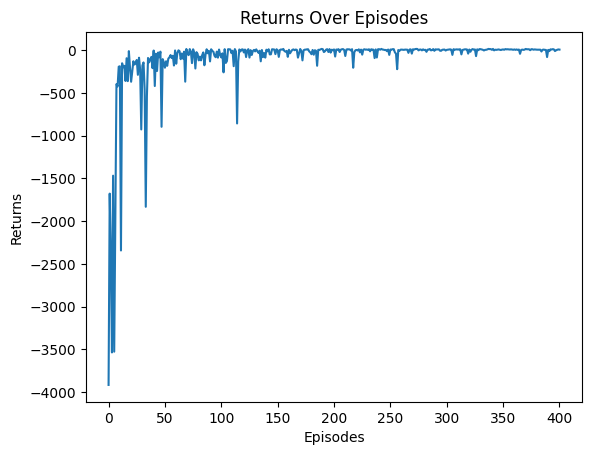

In [6]:
import matplotlib.pyplot as plt

plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Training Episode Videos

### Episode 0

In [9]:
Video("./videos/sarsa-episode-0.mp4")

### Episode 100

In [11]:
Video("./videos/sarsa-episode-100.mp4")

### Episode 200

In [16]:
Video("./videos/sarsa-episode-200.mp4")

### Episode 300

In [13]:
Video("./videos/sarsa-episode-300.mp4")

### Episode 400

In [15]:
Video("./videos/sarsa-episode-400.mp4")

## Render Final Model On An Example

In [17]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(ENV_TYPE, render_mode="human")
state, info = env.reset(seed=64)
G = 0
num_steps = 0
terminated = False

while not terminated:
    action = np.argmax(Q[state, :]) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: 4, Steps Taken: 17
